# Overview

We will:

1. Estimate a production function using neural network 
2. Solve a optimization problem using the estimated function

In [228]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from sklearn.preprocessing import StandardScaler
%matplotlib inline

## Single input power production

We will generate *i.i.d* samples of $(x_i, y_i)$ by the following procedure:

1. $\log(x_i) \sim \mathrm{Normal}(0, 1)$, $\log(\epsilon_i) \sim \mathrm{Normal}(0, 0.1)$
2. $y_i = \epsilon x_{i}^{\alpha}$, where $\alpha \in (0, 1)$ is predetermined.

Using the data $\{(x_i, y_i)\}_{i=1}^{n}$, we will estimate the production function $f(x)$ that predicts $y$ by the neural network. 

Then, we will solve the following (unconstrained) maximization problem:

$$
\mathrm{max}_{x}\;\; f(x) - p x
$$
where $p > 0$ is a known parameter that represents the input price. 


The solution with the true function with $\epsilon=1$ is $x^* = \left(\frac{p}{\alpha}\right)^{\frac{1}{\alpha-1}}$.
We expect that the optimization problem obtains a closer value to this.

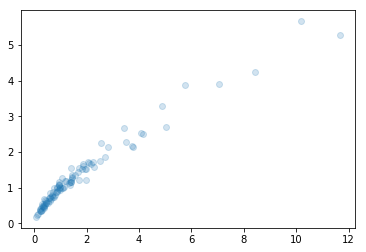

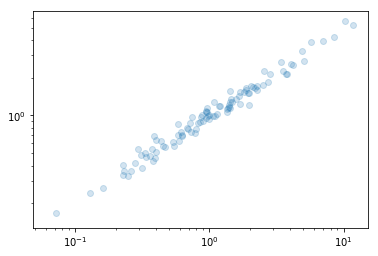

In [229]:
# define data generating functions
def power_product_func(x, epsilon, alpha):
    y = epsilon * np.power(x, alpha)
    return y

def generate_power_data(n, alpha):
    x = np.random.lognormal(0, 1, n)
    eps = np.random.lognormal(0, 0.1, n)
    y = power_product_func(x, eps, alpha)
    return x, y

# test
np.random.seed(87)
x, y = generate_power_data(100, 0.7)
plt.scatter(x, y, alpha=0.2)
plt.show()

plt.scatter(x, y, alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.show()


We will estimate the production function by log-log model, *i.e.,* estimating the mapping from $\log(x)$ to $\log(y)$.
We will fit the data to a neural network model.
Note that for current setting linear regression model would suffice since the data-generating model can be written as $\log(y_i) = \alpha \log(x_i) + \log(\epsilon).$
Nonetheless we use neural network pretending that we do not know the underlining model.

In [230]:
# define estimating architecture
tf.reset_default_graph()
n_hidden = 32

x_in = tf.placeholder(tf.float32, shape=[None, 1], name="x_in")
y_in = tf.placeholder(tf.float32, shape=[None, 1], name="y_in")

keep_prob = tf.placeholder_with_default(1.0, shape=(), name="keep_prob")
train_rate = tf.placeholder_with_default(0.2, shape=(), name="train_rate")


## convert to log scale
log_x = tf.log(x_in)
log_y = tf.log(y_in)


## first hidden layer
w1 = tf.get_variable("w1", [1, n_hidden], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable("b1", [n_hidden]   , initializer=tf.contrib.layers.xavier_initializer())
a1 = tf.nn.tanh(tf.matmul(log_x, w1) + b1)
a1_drop = tf.nn.dropout(a1, keep_prob=keep_prob)

## second hidden layer
w2 = tf.get_variable("w2", [n_hidden, n_hidden], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2", [n_hidden]          , initializer=tf.contrib.layers.xavier_initializer())
a2 = tf.nn.tanh(tf.matmul(a1_drop, w2) + b2)
a2_drop = tf.nn.dropout(a2, keep_prob=keep_prob)

## output layer
w3 = tf.get_variable("w3", [n_hidden, 1], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.get_variable("b3", [1]    , initializer=tf.contrib.layers.xavier_initializer())
log_yhat = tf.matmul(a2_drop, w3) + b3

## training
loss  = tf.reduce_mean(tf.square(log_yhat - log_y))
train = tf.train.GradientDescentOptimizer(train_rate).minimize(loss)

## prediction in the original scale
yhat = tf.exp(log_yhat)

In [231]:
# data prep
np.random.seed(87)

alpha = 0.5
n_tr = 1000
# training data
x_tr, y_tr = generate_power_data(n_tr, alpha)
# test data
n_te = 250
x_te, y_te = generate_power_data(n_te, alpha)


data = {x_in: x_tr.reshape((-1, 1)), y_in: y_tr.reshape((-1, 1)), 
        keep_prob: 0.5, train_rate: 0.1}
data_te = {x_in: x_te.reshape((-1, 1))}

In [232]:
tf.set_random_seed(875)
nepoch = 5000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(nepoch):
        sess.run(train, data)
        if i % (nepoch/10) == 0:
            print(i, ") loss:", sess.run(loss, data))
            
    print(sess.run(loss, data))

    # generate test data and predictioni
    yhat_te = sess.run(yhat, data_te)
    parameters = {'w1': w1.eval(), 'b1': b1.eval(), 
                  'w2': w2.eval(), 'b2': b2.eval(),
                  'w3': w3.eval(), 'b3': b3.eval()}

(0, ') loss:', 0.80030066)
(500, ') loss:', 0.03370437)
(1000, ') loss:', 0.029933266)
(1500, ') loss:', 0.02864904)
(2000, ') loss:', 0.027153963)
(2500, ') loss:', 0.029127713)
(3000, ') loss:', 0.026272753)
(3500, ') loss:', 0.026057623)
(4000, ') loss:', 0.024968723)
(4500, ') loss:', 0.026468262)
0.0240339


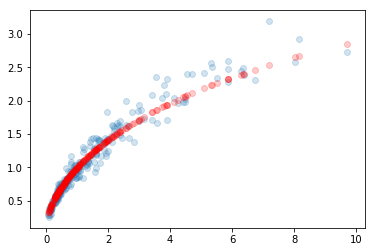

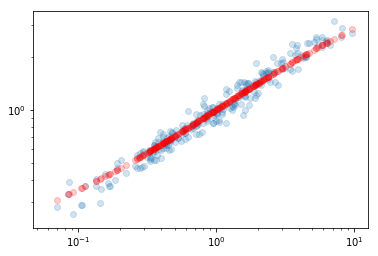

In [233]:
plt.scatter(x_te, y_te, alpha=0.2)
plt.scatter(x_te, yhat_te, c='r', alpha=0.2)
plt.show()

plt.scatter(x_te, y_te, alpha=0.2)
plt.scatter(x_te, yhat_te, c='r', alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [234]:
# define optimization architecture
tf.reset_default_graph()

## x is now a trainable variable
log_x = tf.get_variable('log_x', shape=[1,1], dtype=tf.float32, 
                        initializer=tf.contrib.layers.xavier_initializer())

## first hidden layer
## note that parameters are now constant
w1 = tf.constant(parameters['w1'], dtype=tf.float32, name="w1")
b1 = tf.constant(parameters['b1'], dtype=tf.float32, name="b1")
a1 = tf.nn.relu(tf.matmul(log_x, w1) + b1)
#a1_drop = tf.nn.dropout(a1, keep_prob=keep_prob)  # no need anymore!

## second hidden layer
w2 = tf.constant(parameters['w2'], dtype=tf.float32, name="w2")
b2 = tf.constant(parameters['b2'], dtype=tf.float32, name="b2")
a2 = tf.nn.relu(tf.matmul(a1, w2) + b2)
# a2_drop = tf.nn.dropout(a2, keep_prob=keep_prob)

## output layer
w3 = tf.constant(parameters['w3'], dtype=tf.float32, name="w3")
b3 = tf.constant(parameters['b3'], dtype=tf.float32, name="b3")
log_yhat = tf.matmul(a2, w3) + b3

yhat = tf.exp(log_yhat)
x = tf.exp(log_x)


## optimizer
train_rate = tf.placeholder_with_default(0.2, shape=(), name="train_rate")
price= tf.placeholder(tf.float32, shape=(), name="price")
objective = tf.squeeze(price * x - yhat)
train = tf.train.GradientDescentOptimizer(train_rate).minimize(objective)

In [236]:
tf.set_random_seed(875)
p = 3.3
data = {price: p, train_rate: 0.1}

nepoch = 3000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(nepoch):
        sess.run(train, data)
    x_star = x.eval(data)[0][0]
print("x star (log)) = %f (%f)" % (x_star, np.log(x_star)))
expected = (p/alpha)**(1/(alpha-1))
print("expected (log) = %f (%f)" % (expected, np.log(expected)))

x star (log)) = 0.024342 (-3.715549)
expected (log) = 0.022957 (-3.774139)


### Two-input Cobb-Douglas Production

We will generate a dummy data of $(K, L, Y)$ from $Y = K^\alpha L^{1-\alpha}$ and estimate $Y = f(K, L)$ by neural net. Then, we will maximize: $f(K, L)$ subject to $r K + w L = M$.

This optimization problem has an analytic solution:

$K^* = \frac{\alpha M}{r}, L^* = \frac{(1-\alpha)M}{w}$